In [25]:
#!pip install -U featuretools
#!python -m pip install graphviz

In [2]:
import pandas as pd
import numpy as np
import featuretools as ft
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display, HTML
import matplotlib.pyplot as plt


from woodwork.logical_types import Categorical, PostalCode


# Data Set
Source: https://www.kaggle.com/code/willkoehrsen/automated-feature-engineering-tutorial

Tables:
* clients: information about clients at a credit union
* loans: previous loans taken out by the clients
* payments: payments made/missed on the previous loans


In [84]:
# Load Data
clients = pd.read_csv('./data/clients.csv', parse_dates = ['joined'])
clients['joined'] = pd.to_datetime(clients['joined']).dt.date

loans = pd.read_csv('./data/loans.csv', parse_dates = ['loan_start', 'loan_end'])
loans['loan_start'] = pd.to_datetime(loans['loan_start']).dt.date
loans['loan_end'] = pd.to_datetime(loans['loan_end']).dt.date

payments = pd.read_csv('./data/payments.csv', parse_dates = ['payment_date'])
payments['payment_date'] = pd.to_datetime(payments['payment_date']).dt.date

# payments add index as column
payments['payment_id'] = payments.index

## move payment_id to first column
cols = payments.columns.tolist()
cols = cols[-1:] + cols[:-1]
payments = payments[cols]


In [100]:
# Sample data
# Specify the customer and loans of interest
customer_id = 26326
loans_of_interest = [11251,11988]
loans_of_interest = loans[(loans['client_id'] == customer_id)]['loan_id']

# Filter data for the specified customer and loans
clients_subset = clients[clients['client_id'] == customer_id]
loans_subset = loans[(loans['loan_id'].isin(loans_of_interest))].sort_values(by = 'loan_start')

payments_subset = payments[payments['loan_id'].isin(loans_of_interest)]


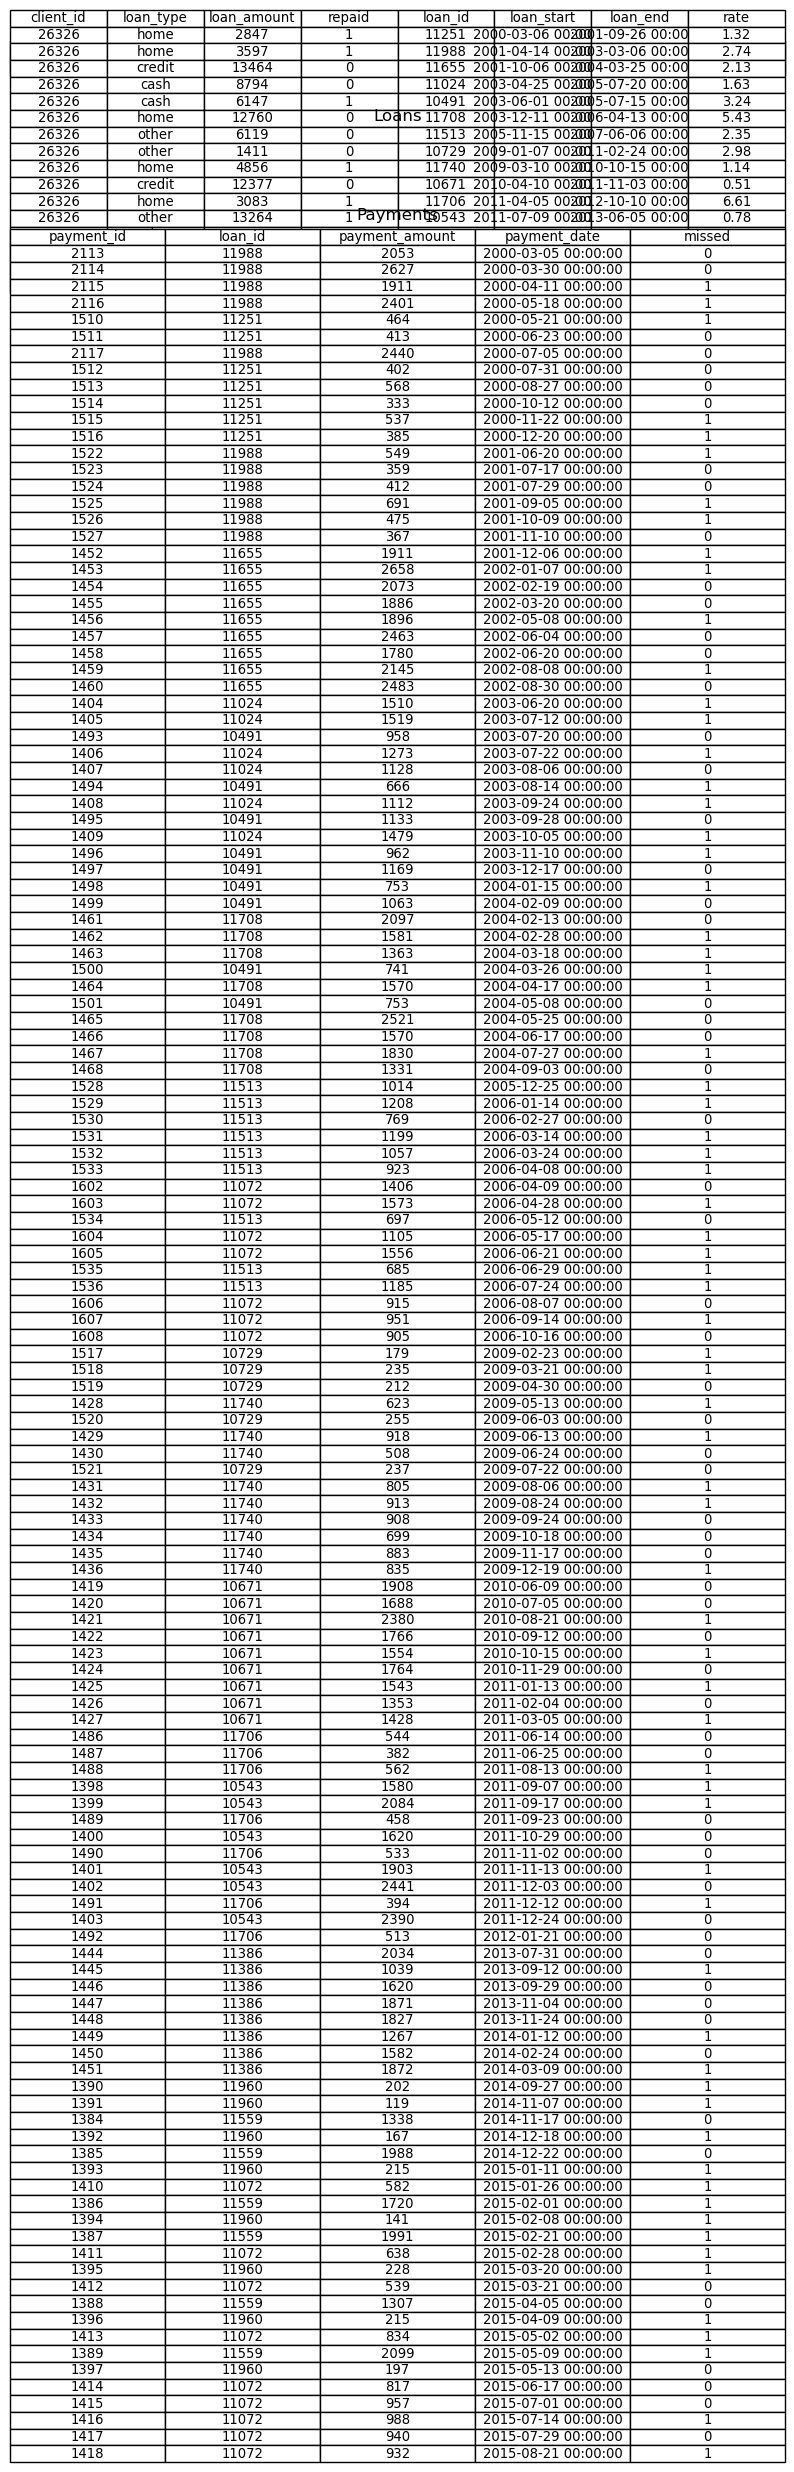

In [83]:

# Assuming you have imported necessary libraries and defined dataframes (clients_subset, loans_subset, payments_subset)

# Visualize the data tables
fig, axs = plt.subplots(3, 1, figsize=(10, 2))

# Set the font size to 10x
font_size = 9.5

axs[0].axis('off')
table0 = axs[0].table(cellText=clients_subset.values, colLabels=clients_subset.columns, cellLoc='center', loc='top')
table0.auto_set_font_size(False)
table0.set_fontsize(font_size)
axs[0].set_title('Clients', y=1.6)

axs[1].axis('off')
table1 = axs[1].table(cellText=loans_subset.values, colLabels=loans_subset.columns, cellLoc='center', loc='center')
table1.auto_set_font_size(False)
table1.set_fontsize(font_size)
axs[1].set_title('Loans')

axs[2].axis('off')
table2 = axs[2].table(cellText=payments_subset.values, colLabels=payments_subset.columns, cellLoc='center', loc='bottom')
table2.auto_set_font_size(False)
table2.set_fontsize(font_size)
axs[2].set_title('Payments', y=0.0)

plt.show()




## Data Representation with EntitySets
An EntitySet is a collection of dataframes and the relationships between them. They are useful for preparing raw, structured datasets for feature engineering. While many functions in Featuretools take dataframes and relationships as separate arguments, it is recommended to create an EntitySet, so you can more easily manipulate your data as needed.



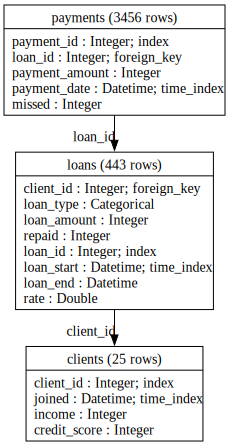

In [57]:
es = ft.EntitySet(id = 'clients')

## Entities Dataframe
es = es.add_dataframe(
    dataframe_name="clients",
    dataframe=clients,
    index="client_id",
    time_index="joined")

es = es.add_dataframe(
    dataframe_name="loans",
    dataframe=loans,
    index="loan_id",
    time_index="loan_start")

es = es.add_dataframe(
    dataframe_name="payments",
    dataframe=payments,
    index="payment_id",
    time_index="payment_date")

## Adding Relationships in dataframes

# Relationship between clients and previous loans
ed = es.add_relationship('clients', 'client_id', 'loans', 'client_id')

# Relationship between previous loans and previous payments
es = es.add_relationship('loans', 'loan_id', 'payments', 'loan_id')
es.plot()


In [17]:
es

Entityset: clients
  DataFrames:
    clients [Rows: 25, Columns: 4]
    loans [Rows: 443, Columns: 8]
    payments [Rows: 3456, Columns: 5]
  Relationships:
    loans.client_id -> clients.client_id
    payments.loan_id -> loans.loan_id

# Feature primitives
Feature primitives are the building blocks of Featuretools. They define individual computations that can be applied to raw datasets to create new features. Because a primitive only constrains the input and output data types, they can be applied across datasets and can stack to create new calculations.

Feature primitives fall into two categories:

1. Aggregation: function that groups together child datapoints for each parent and then calculates a statistic such as mean, min, max, or standard deviation. An example is calculating the maximum loan amount for each client. An aggregation works across multiple tables using relationships between tables.
2. Transformation: an operation applied to one or more columns in a single table. An example would be extracting the day from dates, or finding the difference between two columns in one table.

In [9]:
primitives = ft.list_primitives()
# Set the maximum number of rows and columns to display
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)

In [10]:
# Aggregation primitives
primitives[primitives['type'] == 'aggregation'].head(10)


,name,type,dask_compatible,spark_compatible,description,valid_inputs,return_type
0,min_count,aggregation,False,False,Calculates the number of occurrences of the mi...,<ColumnSchema (Semantic Tags = ['numeric'])>,<ColumnSchema (Logical Type = IntegerNullable)...
1,first,aggregation,False,False,Determines the first value in a list.,<ColumnSchema>,None
2,is_monotonically_increasing,aggregation,False,False,Determines if a series is monotonically increa...,<ColumnSchema (Semantic Tags = ['numeric'])>,<ColumnSchema (Logical Type = BooleanNullable)>
3,sum,aggregation,True,True,"Calculates the total addition, ignoring `NaN`.",<ColumnSchema (Semantic Tags = ['numeric'])>,<ColumnSchema (Semantic Tags = ['numeric'])>
4,n_unique_days_of_calendar_year,aggregation,False,False,Determines the number of unique calendar days.,<ColumnSchema (Logical Type = Datetime)>,<ColumnSchema (Logical Type = Integer) (Semant...
5,skew,aggregation,False,False,Computes the extent to which a distribution di...,<ColumnSchema (Semantic Tags = ['numeric'])>,<ColumnSchema (Semantic Tags = ['numeric'])>
6,count_less_than,aggregation,False,False,Determines the number of values less than a co...,<ColumnSchema (Semantic Tags = ['numeric'])>,<ColumnSchema (Logical Type = Integer) (Semant...
7,n_unique_days_of_month,aggregation,False,False,Determines the number of unique days of month.,<ColumnSchema (Logical Type = Datetime)>,<ColumnSchema (Logical Type = Integer) (Semant...
8,num_true_since_last_false,aggregation,False,False,Calculates the number of 'True' values since t...,<ColumnSchema (Logical Type = Boolean)>,<ColumnSchema (Logical Type = IntegerNullable)...
9,any,aggregation,True,False,Determines if any value is 'True' in a list.,<ColumnSchema (Logical Type = BooleanNullable)...,<ColumnSchema (Logical Type = Boolean)>


In [28]:
# transform primitives
primitives[primitives['type'] == 'transform'].head(10)


,name,type,dask_compatible,spark_compatible,description,valid_inputs,return_type
65,rolling_min,transform,False,False,Determines the minimum of entries over a given...,"<ColumnSchema (Semantic Tags = ['numeric'])>, ...",<ColumnSchema (Logical Type = Double) (Semanti...
66,year,transform,True,True,Determines the year value of a datetime.,<ColumnSchema (Logical Type = Datetime)>,"<ColumnSchema (Logical Type = Ordinal: [1, 2, ..."
67,exponential_weighted_std,transform,False,False,Computes the exponentially weighted moving sta...,<ColumnSchema (Semantic Tags = ['numeric'])>,<ColumnSchema (Logical Type = Double) (Semanti...
68,modulo_by_feature,transform,True,True,Computes the modulo of a scalar by each elemen...,<ColumnSchema (Semantic Tags = ['numeric'])>,<ColumnSchema (Semantic Tags = ['numeric'])>
69,is_weekend,transform,True,True,Determines if a date falls on a weekend.,<ColumnSchema (Logical Type = Datetime)>,<ColumnSchema (Logical Type = BooleanNullable)>
70,add_numeric,transform,True,True,Performs element-wise addition of two lists.,<ColumnSchema (Semantic Tags = ['numeric'])>,<ColumnSchema (Semantic Tags = ['numeric'])>
71,natural_logarithm,transform,True,True,Computes the natural logarithm of a number.,<ColumnSchema (Semantic Tags = ['numeric'])>,<ColumnSchema (Logical Type = Double) (Semanti...
72,multiply_numeric_boolean,transform,True,False,Performs element-wise multiplication of a nume...,<ColumnSchema (Logical Type = BooleanNullable)...,<ColumnSchema (Semantic Tags = ['numeric'])>
73,expanding_count,transform,False,False,Computes the expanding count of events over a ...,<ColumnSchema (Logical Type = Datetime) (Seman...,<ColumnSchema (Logical Type = IntegerNullable)...
74,longitude,transform,False,False,Returns the second tuple value in a list of La...,<ColumnSchema (Logical Type = LatLong)>,<ColumnSchema (Semantic Tags = ['numeric'])>


In [56]:
es

Entityset: clients
  DataFrames:
    clients [Rows: 25, Columns: 4]
    loans [Rows: 443, Columns: 8]
    payments [Rows: 3456, Columns: 5]
  Relationships:
    loans.client_id -> clients.client_id
    payments.loan_id -> loans.loan_id

In [181]:
cutoff_times = pd.DataFrame()

cutoff_times['payment_id'] = payments['payment_id']
cutoff_times['time'] = payments['payment_date']
cutoff_times['time'] = pd.to_datetime(cutoff_times['time'])
# subtract 1 day from the time
cutoff_times['time'] = cutoff_times['time'] - pd.Timedelta(1, 'days')


cutoff_times['label'] = True


cutoff_times.sort_values(by = 'time', inplace = True)
cutoff_times.reset_index(inplace = True, drop = True)
cutoff_times



,payment_id,time,label
0,2113,2000-03-04 23:59:59,True
1,726,2000-03-18 23:59:59,True
2,2114,2000-03-29 23:59:59,True
3,3223,2000-04-04 23:59:59,True
4,2115,2000-04-10 23:59:59,True
...,...,...,...
3451,1415,2015-06-30 23:59:59,True
3452,1308,2015-07-05 23:59:59,True
3453,1416,2015-07-13 23:59:59,True
3454,1417,2015-07-28 23:59:59,True


In [185]:
## Create feature per payment entry

agg_primitives =  ["sum","count"]
trans_primitives = ["time_since_previous"]

# Deep feature synthesis 
f, feature_names = ft.dfs(entityset=es, target_dataframe_name='payments',
                       agg_primitives = agg_primitives,
                       trans_primitives = trans_primitives,
                       n_jobs = -1, verbose = 1,
                       cutoff_time = cutoff_times,                    
                       cutoff_time_in_index = True,
                       max_depth = 3)

feature_names


Built 24 features
Elapsed: 00:00 | Progress:   0%|          

EntitySet scattered to 8 workers in 17 seconds
Elapsed: 02:40 | Progress: 100%|██████████


[<Feature: loan_id>,
 <Feature: payment_amount>,
 <Feature: missed>,
 <Feature: TIME_SINCE_PREVIOUS(payment_date)>,
 <Feature: loans.client_id>,
 <Feature: loans.loan_type>,
 <Feature: loans.loan_amount>,
 <Feature: loans.repaid>,
 <Feature: loans.rate>,
 <Feature: loans.COUNT(payments)>,
 <Feature: loans.SUM(payments.missed)>,
 <Feature: loans.SUM(payments.payment_amount)>,
 <Feature: loans.TIME_SINCE_PREVIOUS(loan_start)>,
 <Feature: loans.clients.income>,
 <Feature: loans.clients.credit_score>,
 <Feature: loans.SUM(payments.TIME_SINCE_PREVIOUS(payment_date))>,
 <Feature: loans.clients.COUNT(loans)>,
 <Feature: loans.clients.SUM(loans.loan_amount)>,
 <Feature: loans.clients.SUM(loans.rate)>,
 <Feature: loans.clients.SUM(loans.repaid)>,
 <Feature: loans.clients.COUNT(payments)>,
 <Feature: loans.clients.SUM(payments.missed)>,
 <Feature: loans.clients.SUM(payments.payment_amount)>,
 <Feature: loans.clients.TIME_SINCE_PREVIOUS(joined)>]

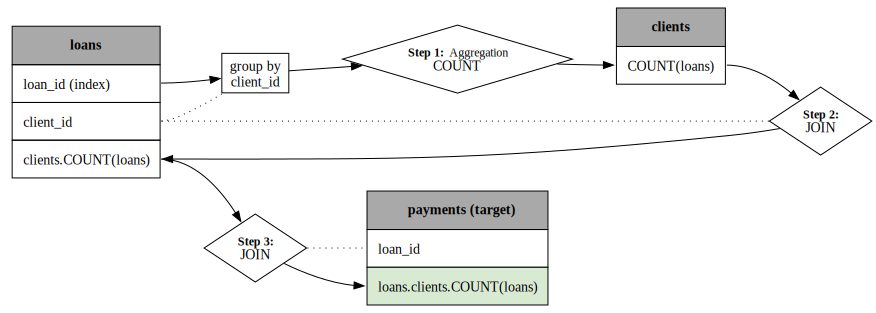

In [188]:
# Visualize the feature
graph_feature = ft.graph_feature(feature_names[16])
graph_feature



In [189]:
f.reset_index(inplace = True)
f[f.payment_id == 1510].head(10)

,payment_id,time,loan_id,payment_amount,missed,TIME_SINCE_PREVIOUS(payment_date),loans.client_id,loans.loan_type,loans.loan_amount,loans.repaid,loans.rate,loans.COUNT(payments),loans.SUM(payments.missed),loans.SUM(payments.payment_amount),loans.TIME_SINCE_PREVIOUS(loan_start),loans.clients.income,loans.clients.credit_score,loans.SUM(payments.TIME_SINCE_PREVIOUS(payment_date)),loans.clients.COUNT(loans),loans.clients.SUM(loans.loan_amount),loans.clients.SUM(loans.rate),loans.clients.SUM(loans.repaid),loans.clients.COUNT(payments),loans.clients.SUM(payments.missed),loans.clients.SUM(payments.payment_amount),loans.clients.TIME_SINCE_PREVIOUS(joined),label
11,1510,2000-05-20 23:59:59,<NA>,<NA>,<NA>,NaN,<NA>,NaN,<NA>,<NA>,NaN,0,0.0,0.0,NaN,<NA>,<NA>,0.0,0,0.0,0.0,0.0,0,0.0,0.0,NaN,True


In [175]:
clients_subset
loans_subset
payments_subset[payments_subset['payment_id'] == 1510]



,payment_id,loan_id,payment_amount,payment_date,missed
1510,1510,11251,464,2000-05-21,1


In [176]:
payments_subset.sort_values(by = 'payment_date')
payments_subset[payments_subset['loan_id'] == 11251]


,payment_id,loan_id,payment_amount,payment_date,missed
1510,1510,11251,464,2000-05-21,1
1511,1511,11251,413,2000-06-23,0
1512,1512,11251,402,2000-07-31,0
1513,1513,11251,568,2000-08-27,0
1514,1514,11251,333,2000-10-12,0
1515,1515,11251,537,2000-11-22,1
1516,1516,11251,385,2000-12-20,1


In [145]:
loans_subset.sort_values(by = 'loan_start')

,client_id,loan_type,loan_amount,repaid,loan_id,loan_start,loan_end,rate
208,26326,home,2847,1,11251,2000-03-06,2001-09-26,1.32
210,26326,home,3597,1,11988,2001-04-14,2003-03-06,2.74
204,26326,credit,13464,0,11655,2001-10-06,2004-03-25,2.13
199,26326,cash,8794,0,11024,2003-04-25,2005-07-20,1.63
207,26326,cash,6147,1,10491,2003-06-01,2005-07-15,3.24
...,...,...,...,...,...,...,...,...
198,26326,other,13264,1,10543,2011-07-09,2013-06-05,0.78
203,26326,other,10261,1,11386,2013-05-17,2015-10-07,0.74
197,26326,other,1164,0,11960,2014-08-02,2017-01-29,0.50
196,26326,other,10902,1,11559,2014-09-06,2016-11-14,6.73


In [148]:
feature_values = ft.calculate_feature_matrix(feature_names, entityset=es)
feature_values[feature_values.index == 1510].head(10)

,loan_id,payment_amount,missed,TIME_SINCE_PREVIOUS(payment_date),loans.client_id,loans.loan_type,loans.loan_amount,loans.repaid,loans.rate,loans.COUNT(payments),loans.SUM(payments.missed),loans.SUM(payments.payment_amount),loans.TIME_SINCE_PREVIOUS(loan_start),loans.clients.income,loans.clients.credit_score,loans.SUM(payments.TIME_SINCE_PREVIOUS(payment_date)),loans.clients.COUNT(loans),loans.clients.SUM(loans.loan_amount),loans.clients.SUM(loans.rate),loans.clients.SUM(loans.repaid),loans.clients.COUNT(payments),loans.clients.SUM(payments.missed),loans.clients.SUM(payments.payment_amount),loans.clients.TIME_SINCE_PREVIOUS(joined)
payment_id,,,,,,,,,,,,,,,,,,,,,,,,
1510,11251,464,1,172800.0,26326,home,2847,1,1.32,7,3.0,3102.0,3456000.0,227920,633,1123200.0,16,116321.0,40.28,8.0,133,70.0,155176.0,7257600.0


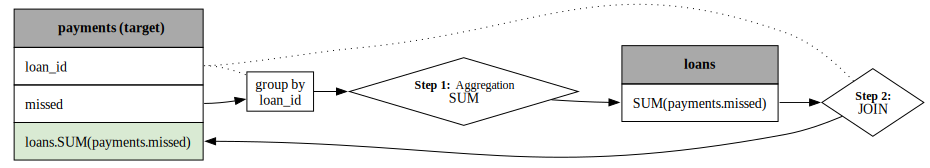

In [41]:
172800.0/(24*60*60)

2.0

In [101]:
graph_feature = ft.graph_feature('<Feature: MIN(loans.TIME_SINCE_PREVIOUS(loan_start))>')
graph_feature


AttributeError: 'str' object has no attribute 'get_name'

In [66]:
feature_values = ft.calculate_feature_matrix(feature_names, entityset=es)
feature_values

,income,credit_score,SUM(loans.loan_amount),SUM(loans.rate),SUM(loans.repaid),SUM(payments.missed),SUM(payments.payment_amount),SUM(payments.loans.loan_amount),SUM(payments.loans.rate),SUM(payments.loans.repaid)
client_id,,,,,,,,,,
42320,229481,563,105931.0,36.86,9.0,62.0,122578.0,843367.0,302.84,70.0
39384,191204,617,149444.0,67.23,12.0,75.0,174270.0,1161741.0,499.12,84.0
26945,214516,806,106889.0,42.83,6.0,57.0,124261.0,771053.0,330.13,38.0
41472,152214,638,120173.0,63.70,8.0,51.0,118553.0,784731.0,435.36,56.0
46180,43851,562,154017.0,70.05,10.0,62.0,176796.0,1142666.0,578.43,74.0
...,...,...,...,...,...,...,...,...,...,...
35089,131176,771,138784.0,70.27,12.0,79.0,174065.0,1149727.0,530.09,101.0
46958,225709,644,121919.0,41.00,3.0,41.0,123870.0,859094.0,285.21,19.0
39505,153873,610,148481.0,63.81,9.0,72.0,175466.0,1155246.0,466.67,62.0


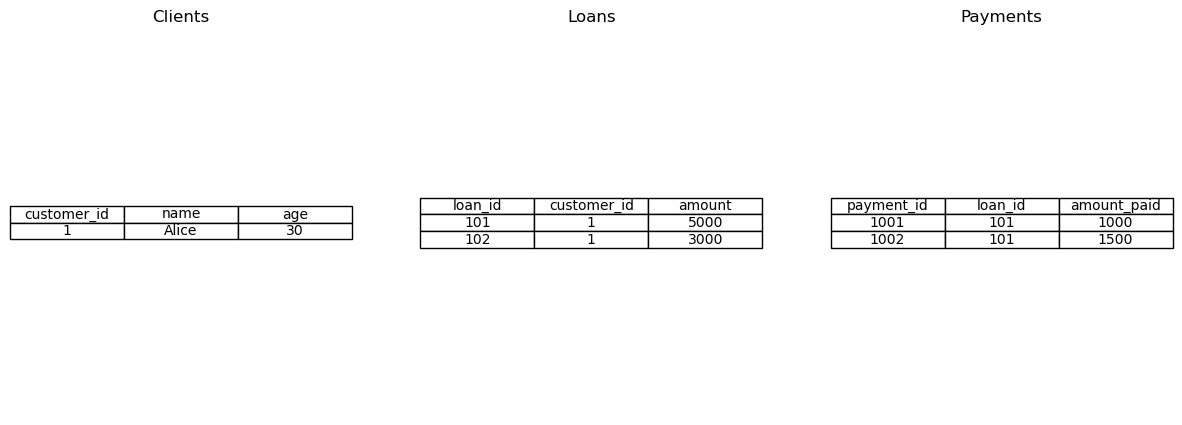

In [105]:
# Sample data
clients_data = {'customer_id': [1, 2],
                'name': ['Alice', 'Bob'],
                'age': [30, 25]}
clients = pd.DataFrame(clients_data)

loans_data = {'loan_id': [101, 102, 201, 202],
              'customer_id': [1, 1, 2, 2],
              'amount': [5000, 3000, 7000, 4000]}
loans = pd.DataFrame(loans_data)

payments_data = {'payment_id': [1001, 1002, 1003, 1004, 1005],
                 'loan_id': [101, 101, 201, 201, 202],
                 'amount_paid': [1000, 1500, 2000, 1000, 1200]}
payments = pd.DataFrame(payments_data)

# Specify the customer and loans of interest
customer_id = 1
loans_of_interest = [101, 102]

# Filter data for the specified customer and loans
clients_subset = clients[clients['customer_id'] == customer_id]
loans_subset = loans[loans['loan_id'].isin(loans_of_interest)]
payments_subset = payments[payments['loan_id'].isin(loans_of_interest)]

# Visualize the data tables
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].axis('off')
axs[0].table(cellText=clients_subset.values, colLabels=clients_subset.columns, cellLoc='center', loc='center')
axs[0].set_title('Clients')

axs[1].axis('off')
axs[1].table(cellText=loans_subset.values, colLabels=loans_subset.columns, cellLoc='center', loc='center')
axs[1].set_title('Loans')

axs[2].axis('off')
axs[2].table(cellText=payments_subset.values, colLabels=payments_subset.columns, cellLoc='center', loc='center')
axs[2].set_title('Payments')

plt.show()


In [92]:
#Changing Target DataFrame
#DFS is powerful because we can create a feature matrix for any dataframe in our dataset. If we switch our target dataframe to “sessions”, we can synthesize features for each session instead of each customer. Now, we can use these features to predict the outcome of a session.

